In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load saved credentials
service = QiskitRuntimeService()

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np
import h5py
from matplotlib import pyplot as plt
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

# Hamiltonian
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator, DensityMatrix, entropy, random_density_matrix

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

import numpy as np
from qiskit.synthesis import OneQubitEulerDecomposer
from qiskit.synthesis import TwoQubitBasisDecomposer
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import CXGate
from qiskit.visualization import plot_histogram, plot_bloch_vector

import h5py
import numpy as np
import pylab
import pandas as pd
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, ADAM, GradientDescent, SPSA
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit.converters import circuit_to_dag

import numpy as np
from qiskit.circuit import ParameterVector
from scipy.optimize import minimize
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate, RXGate
import glob, re

from qiskit.circuit.library import TwoLocal, EvolvedOperatorAnsatz

from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.mappers import ParityMapper

### Delete All HDF5 files

In [70]:
import os
import glob

# Pattern matching all your gates files
pattern = "gates_N*_D*.h5"

for filepath in glob.glob(pattern):
    try:
        os.remove(filepath)
        print(f"Removed {filepath}")
    except OSError as e:
        print(f"Error removing {filepath}: {e}")

# Generating TNQC

### Multiple depths

In [71]:
import glob, re
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate


def load_gates_hdf5(filename):
    gates = {}
    with h5py.File(filename, "r") as file:
        for key in file.keys():
            
            matrix = file[key][:]
            parts = key.split('_')
            gate_str = parts[1] 
            gate_index = int(gate_str.replace("gate", ""))
            
            if matrix.shape == (4,4) and gate_index != 1:
                matrix = np.transpose(matrix)
            
            gates[key] = matrix
            #print(f"{key} loaded with shape {matrix.shape}:\n{matrix}\n")
    return gates

def generate_quantum_circuit_from_dict(gates_dict):
    # 1) Group matrices by layer number and gate index
    layers = {}
    for key, matrix in gates_dict.items():
        layer_str, gate_str = key.split("_")         # e.g. "layer3", "gate2"
        L = int(layer_str.replace("layer", ""))
        G = int(gate_str.replace("gate", ""))
        layers.setdefault(L, {})[G] = matrix

    # 2) Build a list-of-lists: sorted_layers[L_idx] = [mat_gate1, mat_gate2, ...]
    sorted_layers = []
    for L in sorted(layers.keys()):
        # sort gate indices within this layer
        row = [layers[L][g] for g in sorted(layers[L].keys())]
        sorted_layers.append(row)

    # 3) Determine qubit count (gates per layer)
    n = len(sorted_layers[0])
    qc = QuantumCircuit(n)

    # 4) Append gates in layer order
    for L_idx, gate_list in enumerate(sorted_layers, start=1):
        # two-qubit gates on qubits (0,1), (1,2), ..., (n-2,n-1)
        for i, mat in enumerate(gate_list[:-1]):
            qc.append(UnitaryGate(mat, label=f"L{L_idx}G{i+1}"), [i, i+1])
        # single-qubit gate on qubit (n-1)
        qc.append(UnitaryGate(gate_list[-1], label=f"L{L_idx}G{n}"), [n-1])

    return qc

def load_all_tnqc_circuits(n_sites, max_depth=10):
    circuits = {}
    pattern = f"gates_N{n_sites}_D*.h5"
    for fname in sorted(glob.glob(pattern)):
        m = re.match(rf"gates_N{n_sites}_D(\d+)\.h5", fname)
        if not m: 
            continue
        depth = int(m.group(1))
        if 1 <= depth <= max_depth:
            gates = load_gates_hdf5(fname)
            qc = generate_quantum_circuit_from_dict(gates)
            circuits[depth] = qc
            print(f"Loaded depth {depth} → circuit depth {qc.depth()}") 
    return circuits

n_sites = 10
max_depth = 10

circuits_by_depth = load_all_tnqc_circuits(n_sites, max_depth)

#for d, qc in sorted(circuits_by_depth.items()):
#    print(f"D={d}: qubits={qc.num_qubits}, depth={qc.depth()}, gates={qc.count_ops()}")

Loaded depth 1 → circuit depth 10
Loaded depth 10 → circuit depth 28
Loaded depth 2 → circuit depth 12
Loaded depth 3 → circuit depth 14
Loaded depth 4 → circuit depth 16
Loaded depth 5 → circuit depth 18
Loaded depth 6 → circuit depth 20
Loaded depth 7 → circuit depth 22
Loaded depth 8 → circuit depth 24
Loaded depth 9 → circuit depth 26


### one circuit at a time

The resulting circuit with a depth:  10


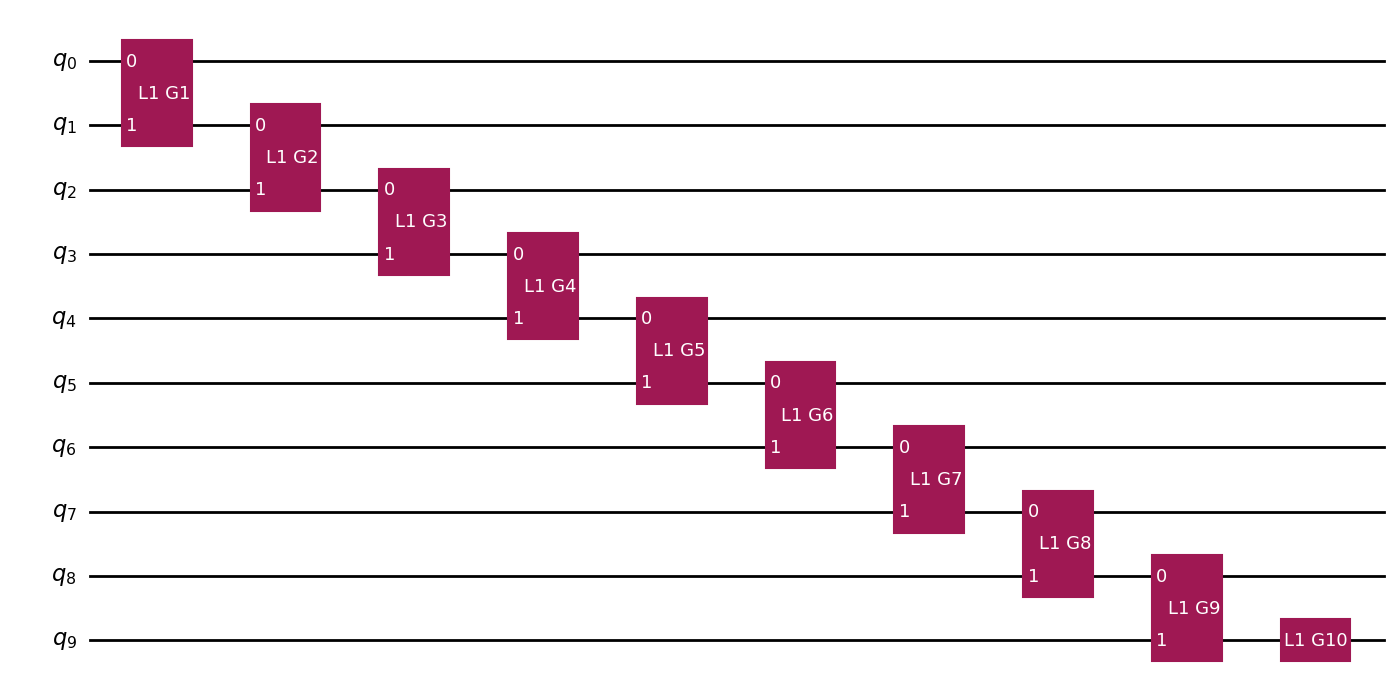

In [72]:
def load_gates_hdf5(filename):
    gates = {}
    with h5py.File(filename, "r") as file:
        for key in file.keys():
            # Load the matrix from file.
            matrix = file[key][:]
            # Parse the key to determine the gate index.
            # Expected key format: "layerX_gateY"
            parts = key.split('_')
            gate_str = parts[1]  # e.g., "gate2"
            gate_index = int(gate_str.replace("gate", ""))
            
            # If it's a two-qubit gate (4x4) and not the first gate, transpose it.
            if matrix.shape == (4,4) and gate_index != 1:
                matrix = np.transpose(matrix)
            
            gates[key] = matrix
            #print(f"{key} loaded with shape {matrix.shape}:\n{matrix}\n")
    return gates

def generate_quantum_circuit_from_dict(gates_dict):
    # Organize gates by layer.
    layers = {}
    for key, matrix in gates_dict.items():
        # key expected to be like "layerX_gateY"
        parts = key.split('_')
        layer_str = parts[0]  # "layerX"
        gate_str  = parts[1]  # "gateY"
        L = int(layer_str.replace("layer", ""))
        G = int(gate_str.replace("gate", ""))
        if L not in layers:
            layers[L] = {}
        layers[L][G] = matrix

    # Sort layers by layer number and sort gates within each layer.
    sorted_layers = {}
    for L in sorted(layers.keys()):
        sorted_layers[L] = [layers[L][g] for g in sorted(layers[L].keys())]

    # Assume the number of qubits is determined by the number of gates in any layer.
    # (Each layer should contain N gates.)
    first_layer = sorted_layers[next(iter(sorted_layers))]
    n = len(first_layer)
    qc = QuantumCircuit(n)

    # For each layer, append the corresponding gates.
    for L in sorted(sorted_layers.keys()):
        gate_list = sorted_layers[L]
        # Append two-qubit gates for indices 0 to n-2.
        for i in range(n - 1):
            # Optionally, if pre-transposition is needed for intermediate gates, you can do so here:
            # gate = UnitaryGate(np.transpose(gate_list[i]), label=f"Layer {L} Gate {i+1}")
            gate = UnitaryGate(gate_list[i], label=f"L{L} G{i+1}")
            qc.append(gate, [i, i+1])
        # Append the final gate (one-qubit) on the last qubit.
        gate = UnitaryGate(gate_list[-1], label=f"L{L} G{n}")
        qc.append(gate, [n-1])
   

    return qc

# Example usage:
gates = load_gates_hdf5("gates_N10_D1.h5")

# Generate the quantum circuit from the loaded multi-layer gates.
qc = generate_quantum_circuit_from_dict(gates)
print("The resulting circuit with a depth: ", qc.depth())
qc.draw("mpl")

### Hamiltonian stuff

In [73]:
def xyz_hamiltonian(N, Jx, Jy, Jz, h):
    pauli_labels = []
    coeffs = []
    
    
    for j in range(N-1):
        
        label = ['I'] * N
        label[j], label[j+1] = 'X', 'X'
        pauli_labels.append(''.join(label))
        coeffs.append(Jx/4)
        
        
        label = ['I'] * N
        label[j], label[j+1] = 'Y', 'Y'
        pauli_labels.append(''.join(label))
        coeffs.append(Jy/4)
        
        
        label = ['I'] * N
        label[j], label[j+1] = 'Z', 'Z'
        pauli_labels.append(''.join(label))
        coeffs.append(Jz/4)
    
   
    for j in range(N):
        label = ['I'] * N
        label[j] = 'X'
        pauli_labels.append(''.join(label))
        coeffs.append(-h/2)
    
    return SparsePauliOp(pauli_labels, coeffs)
N  = 10  # number of qubits
Jx = 5.0      # Sx–Sx coupling
Jy = 6.0       # Sy–Sy coupling
Jz = 5.0       # Sz–Sz coupling
h  = 0.5       # transverse field

hamiltonian = xyz_hamiltonian(N, Jx, Jy, Jz, h)

In [74]:
state = Statevector(qc)
Energy = state.expectation_value(hamiltonian)
print("Theoretical energy of initial guess:", np.real(Energy))

Theoretical energy of initial guess: -20.7724504812718


In [75]:
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=hamiltonian)
groundstate_value = result.eigenvalue.real
print(f"groundstate value: {groundstate_value:.5f}")

groundstate value: -22.74204


### varying varitional depths

In [76]:
def generate_augmented_circuits(circuits_by_depth, max_p=8):

    augmented = {}
    for D, base_qc in circuits_by_depth.items():
        n_qubits = base_qc.num_qubits

        for p in range(1, max_p + 1):
            # collect parameters for this (D,p) ansatz
            params = []
            tail = QuantumCircuit(n_qubits, name=f"var_D{D}_p{p}")

            # build p layers of the 2q+1q pattern
            for layer_idx in range(p):
                # two-qubit rotations across the chain
                for q in range(n_qubits - 1):
                    for GateClass in (RXXGate, RYYGate, RZZGate):
                        φ = Parameter(f"ϕ_D{D}_p{p}_{len(params)}")
                        params.append(φ)
                        tail.append(GateClass(φ), [q, q+1])
                # single-qubit RX on each qubit
                for q in range(n_qubits):
                    φ = Parameter(f"ϕ_D{D}_p{p}_{len(params)}")
                    params.append(φ)
                    tail.append(RXGate(φ), [q])

            # compose the MPS core + variational tail
            full = base_qc.compose(tail, inplace=False)
            full.name = f"MPS{D}_var{p}"
            augmented[(D, p)] = full

    return augmented

augmented_circuits = generate_augmented_circuits(circuits_by_depth, max_p=8)

#print(f"Total circuits generated: {len(augmented_circuits)}")  

# Inspect one
#D, p = 4, 2
#full_circ = augmented_circuits[(D,p)]
#full_circ.draw("mpl")

### one depth

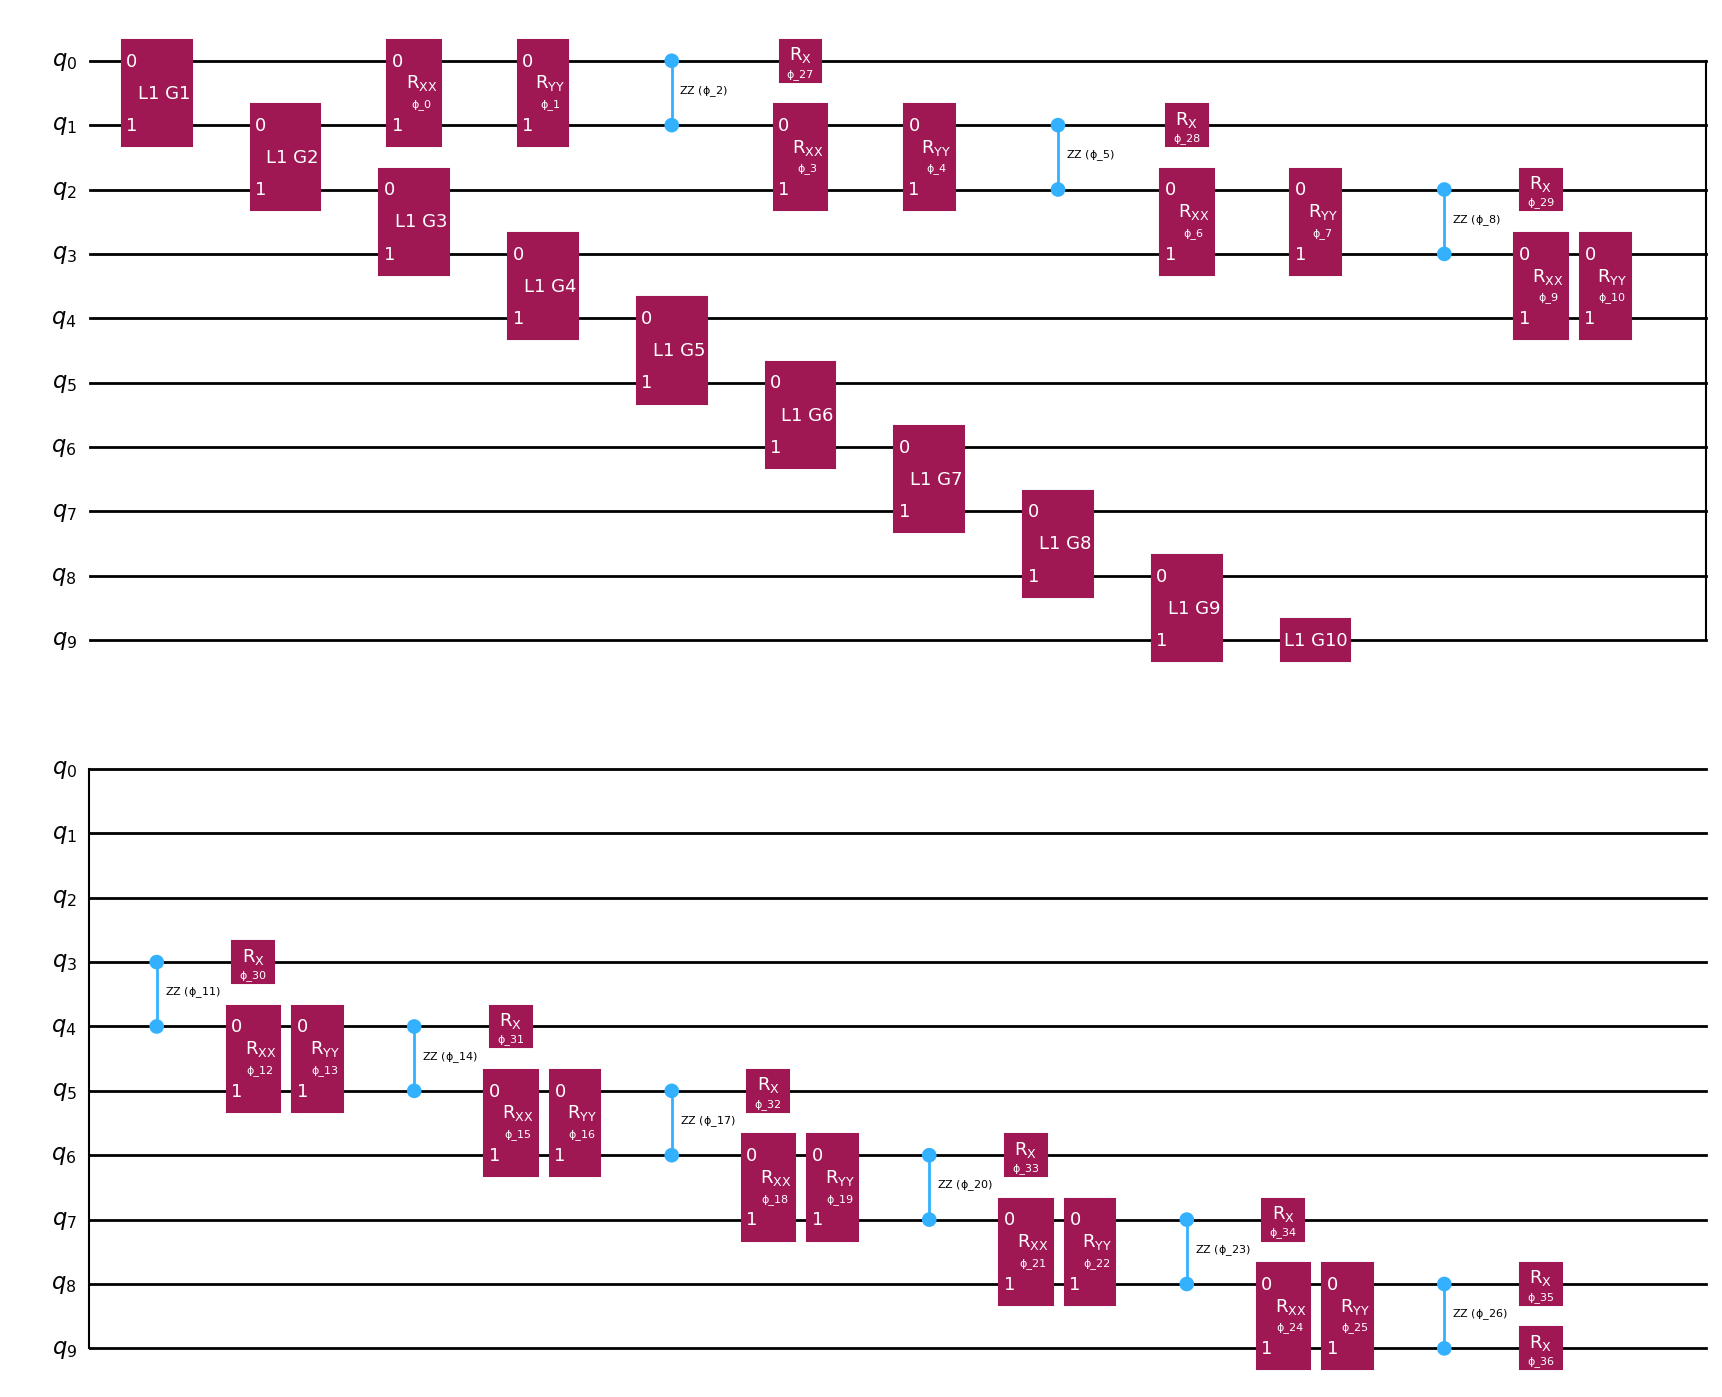

In [46]:
n_qubits = qc.num_qubits
p = 1
params = []
ansatz = QuantumCircuit(n_qubits)

for layer in range(p):
    
    for j in range(n_qubits - 1):
        # RXX
        phi = Parameter(f"ϕ_{len(params)}"); params.append(phi)
        ansatz.append(RXXGate(phi), [j, j+1])
        # RYY
        phi = Parameter(f"ϕ_{len(params)}"); params.append(phi)
        ansatz.append(RYYGate(phi), [j, j+1])
        # RZZ
        phi = Parameter(f"ϕ_{len(params)}"); params.append(phi)
        ansatz.append(RZZGate(phi), [j, j+1])
    # Single-qubit RX field rotations
    for j in range(n_qubits):
        phi = Parameter(f"ϕ_{len(params)}"); params.append(phi)
        ansatz.append(RXGate(phi), [j])

full_circ = qc.compose(ansatz)
full_circ.draw("mpl")

# Optimisation VQE

### many depths - inc. shot and seed number

In [ ]:
seed   = 75
shots  = 1024

estimator = AerEstimator(
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)


H_op = (
    Operator(hamiltonian)
    if isinstance(hamiltonian, np.ndarray)
    else hamiltonian
)

records = []

for (D, p), qc in augmented_circuits.items():
    n_qubits = qc.num_qubits

    params = [
        param
        for param in qc.parameters
        if param.name.startswith(f"ϕ_D{D}_p{p}_")
    ]

    
    def energy_fn(x, qc=qc, params=params, H=H_op):
        # bind the parameters
        bound = qc.assign_parameters(
            {p: v for p, v in zip(params, x)},
            inplace=False
        )
        
        job = estimator.run(circuits=[bound], observables=[H])
        value = job.result().values[0]
        return float(np.real(value))

    
    init_vals = np.ones(len(params))
    res = minimize(
        energy_fn,
        init_vals,
        method='COBYLA',
        options={'maxiter': 2000}        
    )

    
    pct_err = abs((res.fun - groundstate_value) / groundstate_value) * 100

    records.append({
        'qubits':   n_qubits,
        'MPS_depth': D,
        'var_depth': p,
        'pct_error': pct_err
    })

df = pd.DataFrame(records)
df = df.sort_values(['MPS_depth','var_depth']).reset_index(drop=True)
print(df.to_string(index=False))

### for many depths - no shot/seed

In [65]:
records = []
for (D, p), qc in augmented_circuits.items():
    n_qubits = qc.num_qubits

    # --- rebuild the correct H_mat for this circuit ---
    H_mat = (hamiltonian 
         if isinstance(hamiltonian, np.ndarray) 
         else Operator(hamiltonian).data)


    params = [param for param in qc.parameters
              if param.name.startswith(f"ϕ_D{D}_p{p}_")]
    init_vals = np.ones(len(params))

    def energy_fn(x, qc=qc, params=params, H=H_mat):
        bound = qc.assign_parameters({p:v for p,v in zip(params, x)}, inplace=False)
        psi   = Statevector(bound).data
        return float(np.real(np.vdot(psi, H.dot(psi))))

    res = minimize(energy_fn, init_vals, method='COBYLA')
    pct_err = np.abs((res.fun - groundstate_value)/groundstate_value)*100
    energy = res.fun
    
    records.append({
      'qubits':   n_qubits,
      'MPS_depth':D,
      'var_depth':p,
      'pct_error':pct_err,
      'Energy':   energy
    })

df = pd.DataFrame(records)

### visualising many depths

In [66]:
df = pd.DataFrame(records)
df = df.sort_values(['MPS_depth','var_depth']).reset_index(drop=True)
print(df.to_string(index=False))

 qubits  MPS_depth  var_depth  pct_error     Energy
     10          1          1   0.967741 -22.521957
     10          1          2   1.276192 -22.451809
     10          1          3   3.208875 -22.012278
     10          1          4   3.595509 -21.924349
     10          1          5   4.717242 -21.669244
     10          1          6   5.958592 -21.386936
     10          1          7   5.979811 -21.382110
     10          1          8   7.353727 -21.069654
     10          2          1   1.806542 -22.331197
     10          2          2   2.075069 -22.270128
     10          2          3   2.998386 -22.060147
     10          2          4   3.269160 -21.998568
     10          2          5   3.444292 -21.958739
     10          2          6   2.964296 -22.067900
     10          2          7   3.202133 -22.013811
     10          2          8   3.988601 -21.834952
     10          3          1   2.045638 -22.276822
     10          3          2   2.097137 -22.265110
     10     

### Optimal Depth Composition

Lowest error = 0.9677% at MPS_depth=1, var_depth=1


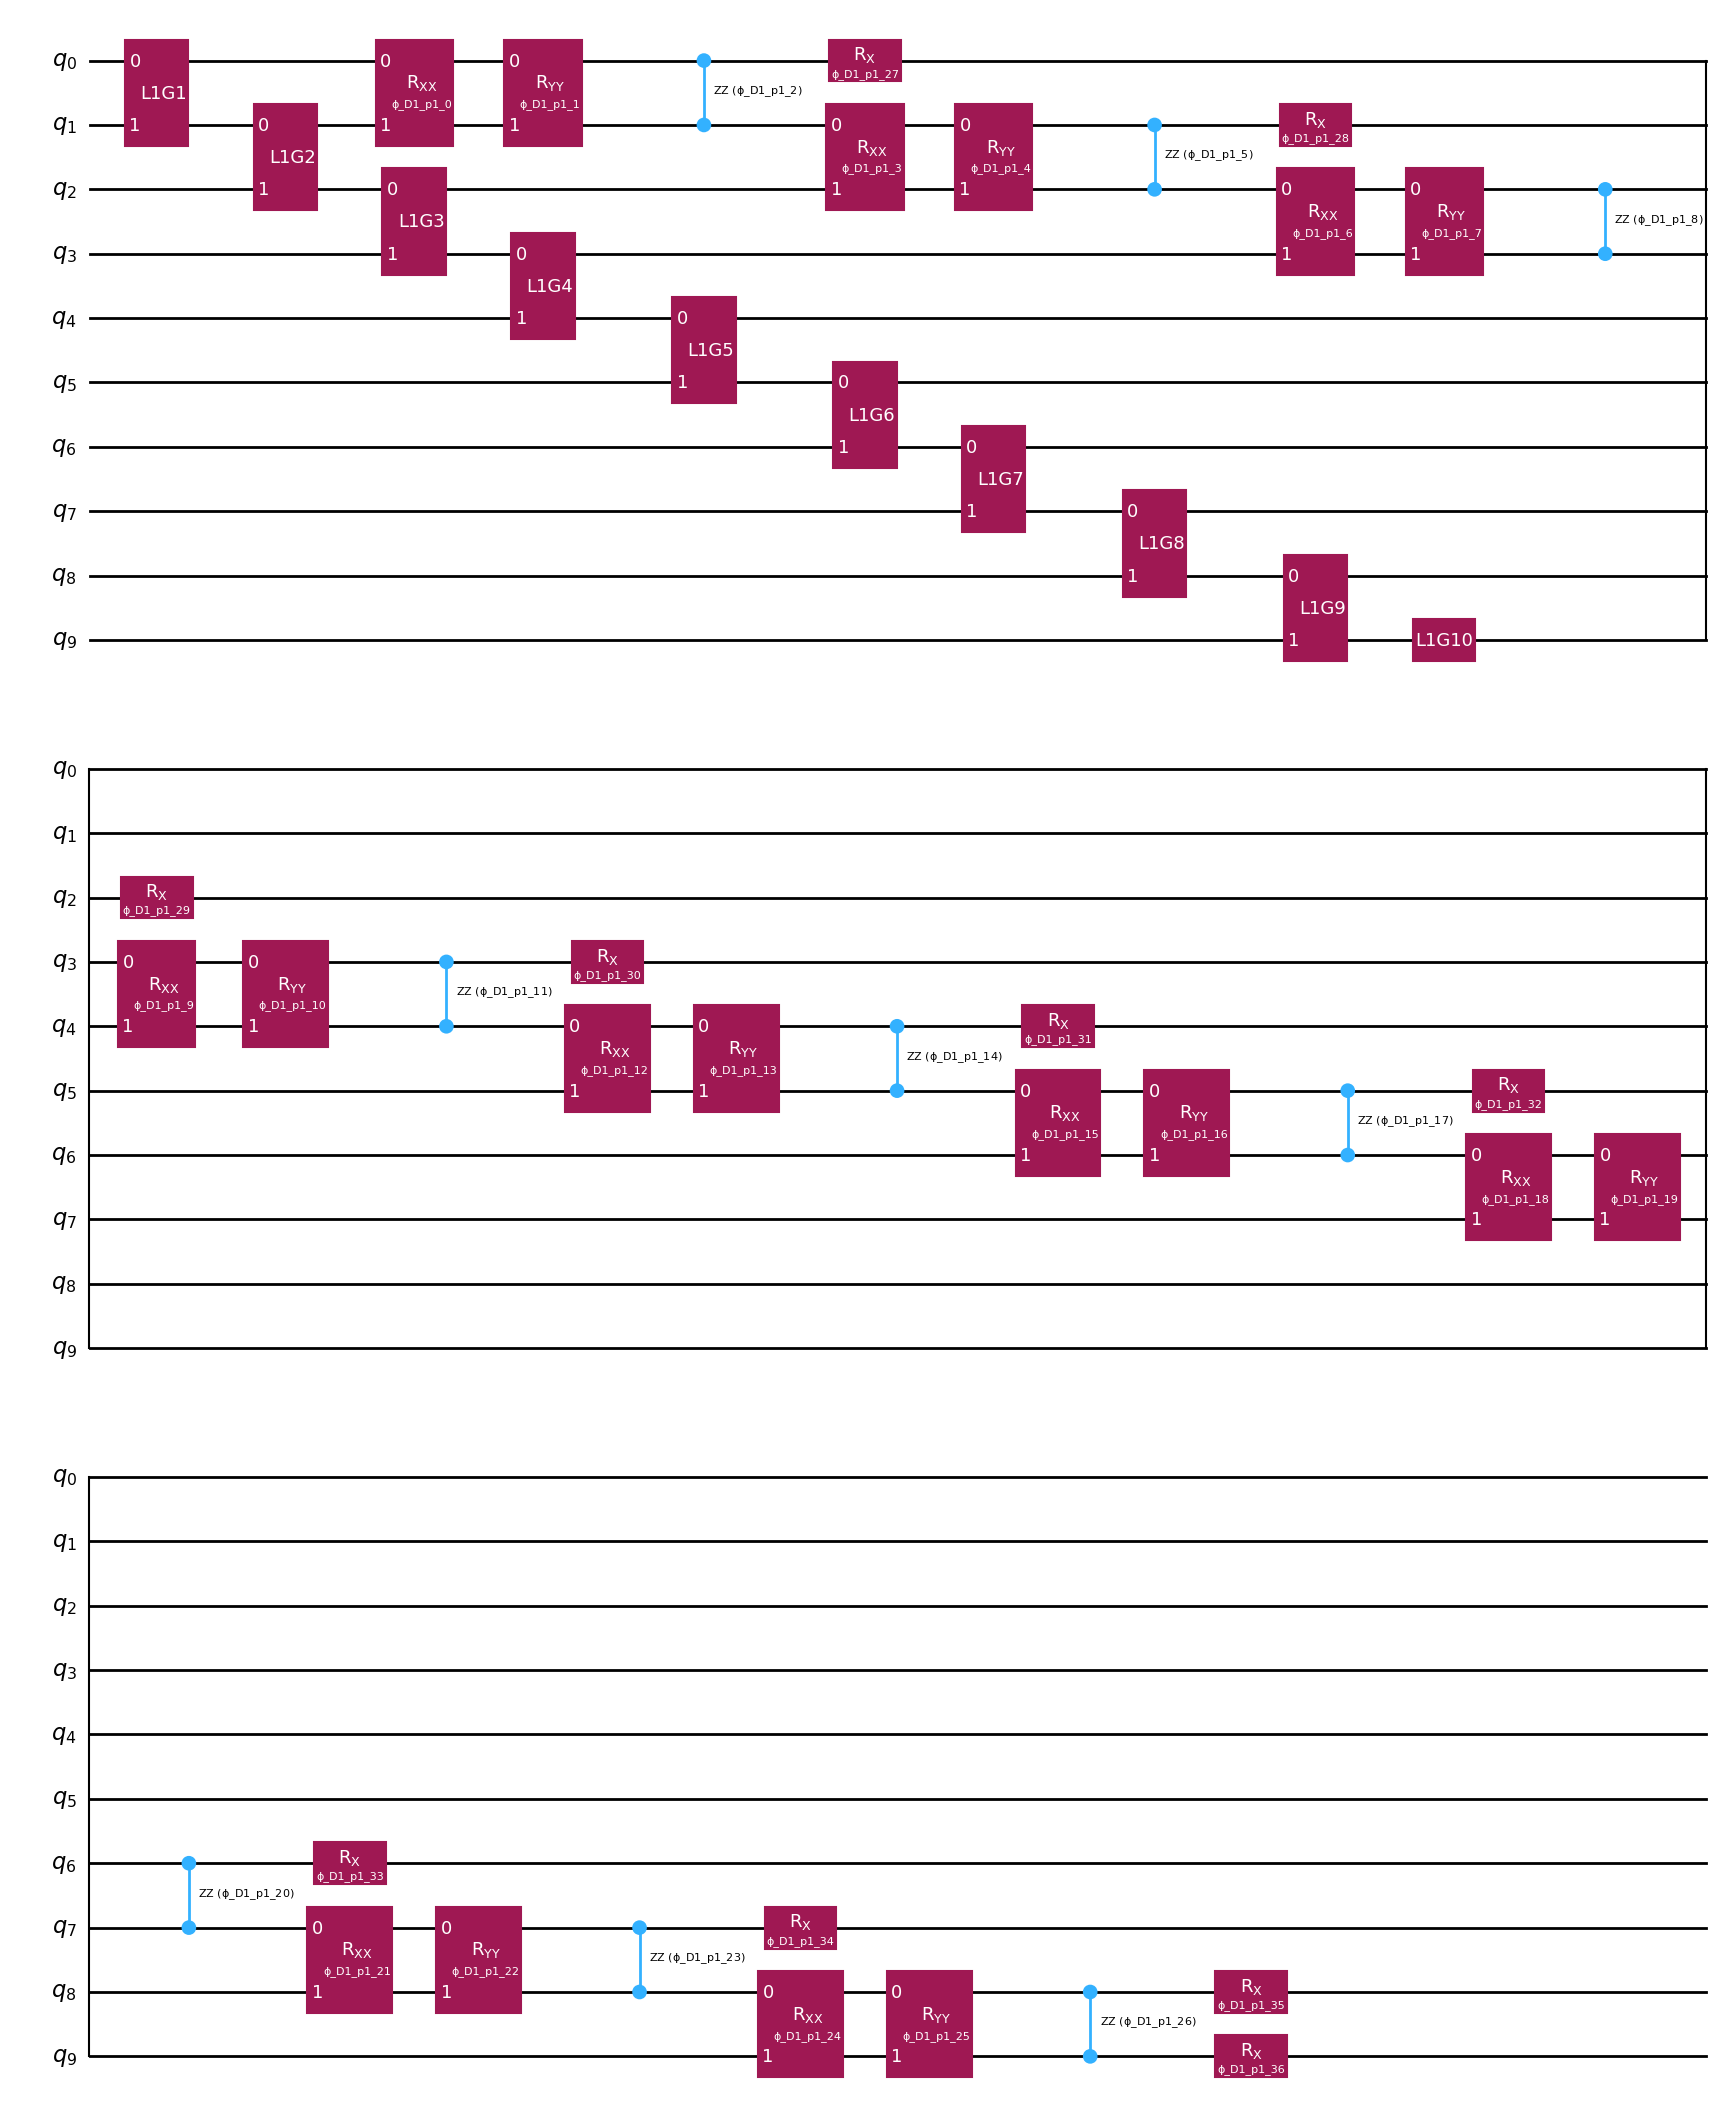

In [67]:
best_idx  = df['pct_error'].idxmin()
best_row  = df.loc[best_idx]
D_best    = int(best_row['MPS_depth'])
p_best    = int(best_row['var_depth'])
err_best  = best_row['pct_error']

print(f"Lowest error = {err_best:.4f}% at MPS_depth={D_best}, var_depth={p_best}")

best_circ = augmented_circuits[(D_best, p_best)]

best_circ.draw('mpl')

#params    = list(best_circ.parameters)
#init_vals = np.ones(len(params))

### Error Landscape

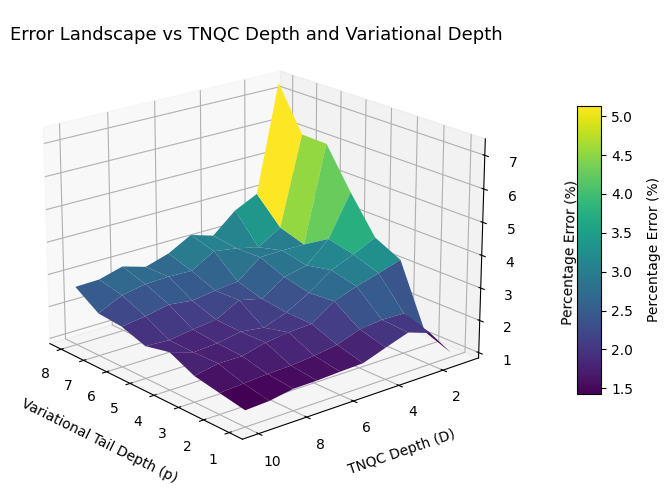

In [405]:
import numpy as np
import matplotlib.pyplot as plt

# your pivot
pivot = df.pivot(index='MPS_depth', columns='var_depth', values='pct_error')

# meshgrid for surface plot
X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
Z = pivot.values

# create a larger figure
fig = plt.figure(figsize=(9, 6))
ax  = fig.add_subplot(111, projection='3d')

# surface with viridis colormap
surf = ax.plot_surface(
    X, Y, Z,
    cmap='viridis',
    edgecolor='none'
)

# axis labels with extra labelpad on z
ax.set_xlabel('Variational Tail Depth (p)', labelpad=10)
ax.set_ylabel('TNQC Depth (D)',        labelpad=10)
ax.set_zlabel('Percentage Error (%)',  labelpad=15)  # push it away from the plot

# title
ax.set_title('Error Landscape vs TNQC Depth and Variational Depth', fontsize=13, y=1.0)

# colorbar with a bit more pad on the left
cbar = fig.colorbar(
    surf, 
    ax=ax,
    shrink=0.6,
    aspect=12,
    pad=0.12,                # move it out to the right
    label='Percentage Error (%)'
)
cbar.ax.set_ylabel('Percentage Error (%)', rotation=90, labelpad=10)

# adjust the overall subplot so labels don't overlap
fig.subplots_adjust(
    left=0.10, 
    right=0.85, 
    bottom=0.10, 
    top=0.90
)

# a better viewing angle
ax.view_init(elev=20, azim=140)

plt.show()




### Baseline surface

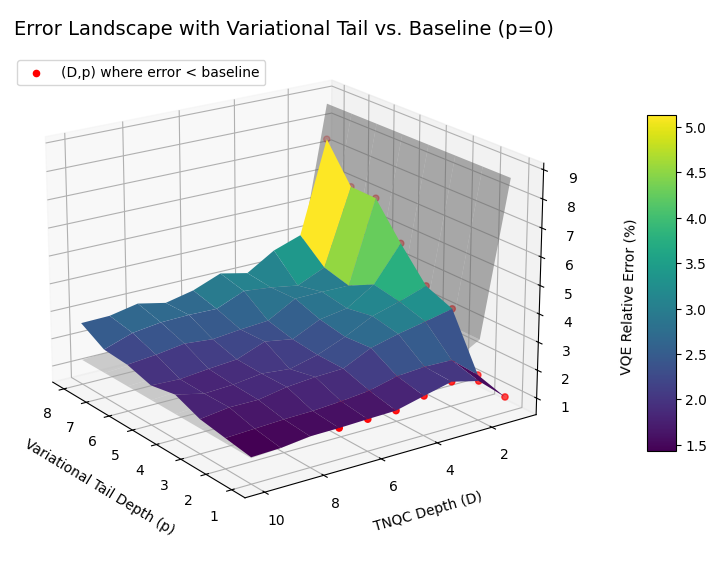

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- (Re-use your existing 'records' list, DataFrame, and pivot step) ---
df = pd.DataFrame(records)
df = df.sort_values(['MPS_depth', 'var_depth']).reset_index(drop=True)

# Create pivot for the full (D,p) surface
pivot = df.pivot(index='MPS_depth', columns='var_depth', values='pct_error')

# Meshgrid for plotting (X = variational depth p, Y = TNQC depth D)
X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
Z = pivot.values  # shape (10,10): rows → D=1..10, cols → p=1..10

# --- Baseline errors for p=0, D=1..10 (as provided) ---
baseline_errors = np.array([
    8.660572271960678,
    3.2770484291442177,
    2.725353662808851,
    2.3493637893328874,
    1.9741874444424892,
    1.7175504222854947,
    1.5786197988854296,
    1.484077844025482,
    1.3643583322234087,
    1.3024408828370007
])  # shape (10,)

# Tile the baseline so that for each D (row) it is constant across all p (columns)
baseline_Z = np.tile(baseline_errors[:, np.newaxis], (1, pivot.columns.size))
# baseline_Z is shape (10,10), with each row i = baseline_errors[i] repeated

# Compute a boolean mask: True wherever the full surface Z lies BELOW the baseline
improve_mask = (Z < baseline_Z)
# … everything up through computing improve_mask … #

# Flattened coordinates where improvement occurs
xs = X[improve_mask]
ys = Y[improve_mask]
zs = Z[improve_mask]     # ← use the actual surface height here

# --- Plot both surfaces plus red dots on the error surface ---
fig = plt.figure(figsize=(10, 7))
ax  = fig.add_subplot(111, projection='3d')

# 1) Main error surface
surf = ax.plot_surface(
    X, Y, Z,
    cmap='viridis',
    edgecolor='none',
    linewidth=0,
    antialiased=True
)

# 2) Baseline surface (for reference)
baseline_surf = ax.plot_surface(
    X, Y, baseline_Z,
    color='lightgray',
    alpha=0.5,
    edgecolor='none'
)

# 3) Red dots on the **error** surface wherever Z < baseline_Z
ax.scatter(
    xs, ys, zs,
    color='red',
    s=20,
    #edgecolors='none',
    label='(D,p) where error < baseline'
)

# Labels, legend, colorbar, view, etc.
ax.set_xlabel('Variational Tail Depth (p)', labelpad=10)
ax.set_ylabel('TNQC Depth (D)',        labelpad=10)
ax.set_zlabel('VQE Relative Error (%)',labelpad=15)

ax.set_title('Error Landscape with Variational Tail vs. Baseline (p=0)', fontsize=14, y=1.02)
ax.legend(loc='upper left', bbox_to_anchor=(0, 0.92))

cbar = fig.colorbar(
    surf,
    ax=ax,
    shrink=0.6,
    aspect=12,
    pad=0.12,
)
ax.view_init(elev=20, azim=145)
fig.subplots_adjust(left=0.10, right=0.85, bottom=0.10, top=0.90)

plt.show()

### Energy Surface

In [40]:
df = pd.DataFrame(records)

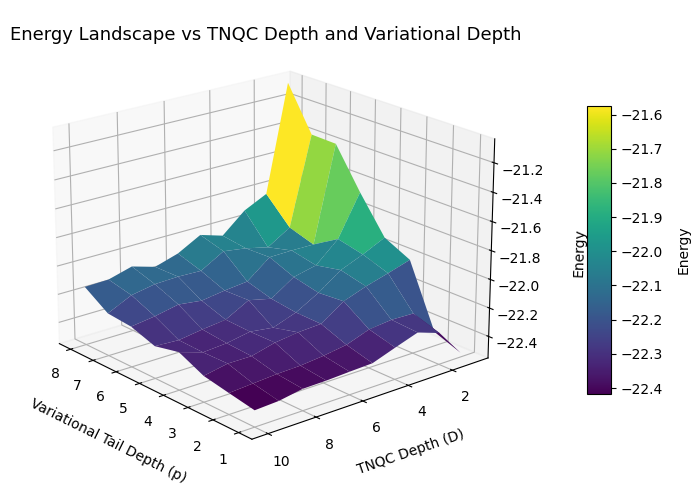

In [80]:
# Pivot the DataFrame on energy instead of pct_error
pivot = df.pivot(index='MPS_depth', columns='var_depth', values='Energy')


# Create meshgrid for surface plot
X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
Z = pivot.values

# Create a larger figure
fig = plt.figure(figsize=(9, 6))
ax  = fig.add_subplot(111, projection='3d')

# Plot the energy surface with viridis colormap
surf = ax.plot_surface(
    X, Y, Z,
    cmap='viridis',
    edgecolor='none'
)

# Axis labels (push z‐label out a bit)
ax.set_xlabel('Variational Tail Depth (p)', labelpad=10)
ax.set_ylabel('TNQC Depth (D)',        labelpad=10)
ax.set_zlabel('Energy',                labelpad=15)

# Title
ax.set_title('Energy Landscape vs TNQC Depth and Variational Depth', fontsize=13, y=1.0)

# Colorbar (moved slightly to the right)
cbar = fig.colorbar(
    surf,
    ax=ax,
    shrink=0.6,
    aspect=12,
    pad=0.12,
    label='Energy'
)
cbar.ax.set_ylabel('Energy', rotation=90, labelpad=10)

# Adjust subplot so labels don’t overlap
fig.subplots_adjust(
    left=0.10,
    right=0.85,
    bottom=0.10,
    top=0.90
)

# A better viewing angle
ax.view_init(elev=20, azim=140)

plt.show()

# for one depth

### Including Shot and Seed number

Energy of TNQC: -13.021970152208675
Energy of initial guess: -11.23291015625
Optimized energy: -13.17333984
Exact ground-state energy: -13.31408031
Energy error: 1.41e-01
Percentage Error (%): 1.0570798934215606


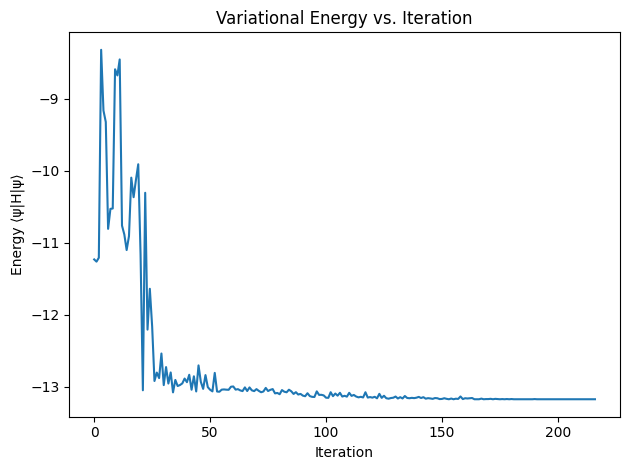

In [251]:
seed   = 75
shots  = 1024


estimator = AerEstimator(
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)



H_op = hamiltonian if not isinstance(hamiltonian, np.ndarray) \
       else Operator(hamiltonian)

def energy(param_vals):

    bound = full_circ.assign_parameters(
        {p: v for p, v in zip(params, param_vals)},
        inplace=False)

    job = estimator.run([bound], [H_op])
    result = job.result()
    
    return float(np.real(result.values[0]))


init_vals = np.ones(len(params))
energies  = []

def record_energy(xk):
    energies.append(energy(xk))

res      = minimize(energy, init_vals, method='COBYLA', callback=record_energy, options={'maxiter': 2000})
opt_vals = res.x

if 'groundstate_value' in globals():
    print("Energy of TNQC:", np.real(Energy))
    print("Energy of initial guess:", np.real(energies[0]))
    print(f"Optimized energy: {res.fun:.8f}")
    print(f"Exact ground-state energy: {groundstate_value:.8f}")
    print(f"Energy error: {res.fun - groundstate_value:.2e}")
    print(f"Percentage Error (%): {(np.abs((res.fun - groundstate_value) / groundstate_value) * 100)}")

plt.figure()
plt.plot(energies)
plt.xlabel('Iteration')
plt.ylabel('Energy ⟨ψ|H|ψ⟩')
plt.title('Variational Energy vs. Iteration')
plt.tight_layout()
plt.show()

### no shot and seed

In [47]:
def energy(param_vals):
    bound = full_circ.assign_parameters({p: v for p, v in zip(params, param_vals)}, inplace=False)
    psi = Statevector.from_instruction(bound).data
    H_mat = hamiltonian if isinstance(hamiltonian, np.ndarray) else Operator(hamiltonian).data
    return np.real(np.vdot(psi, H_mat.dot(psi)))


init_vals = np.ones(len(params))

energies_exact = []

def record_energy(xk):
    energies_exact.append(energy(xk))  
res = minimize(energy, init_vals, method='L-BFGS-B', callback=record_energy)
opt_vals = res.x

if 'groundstate_value' in globals():
    print("Energy of TNQC:", np.real(Energy))
    print("Energy of initial guess:", np.real(energies[0]))
    print(f"Optimized energy: {res.fun:.8f}")
    print(f"Exact ground-state energy: {groundstate_value:.8f}")
    print(f"Energy error: {res.fun - groundstate_value:.2e}")
    print(f"Percentage Error (%): {(np.abs((res.fun - groundstate_value) / groundstate_value) * 100)}")



Energy of TNQC: -20.7724504812718
Energy of initial guess: -21.052187997332084
Optimized energy: -22.60684356
Exact ground-state energy: -22.74204141
Energy error: 1.35e-01
Percentage Error (%): 0.5944842618984147


### Energy Convergence Plot for Truncated Warm Start

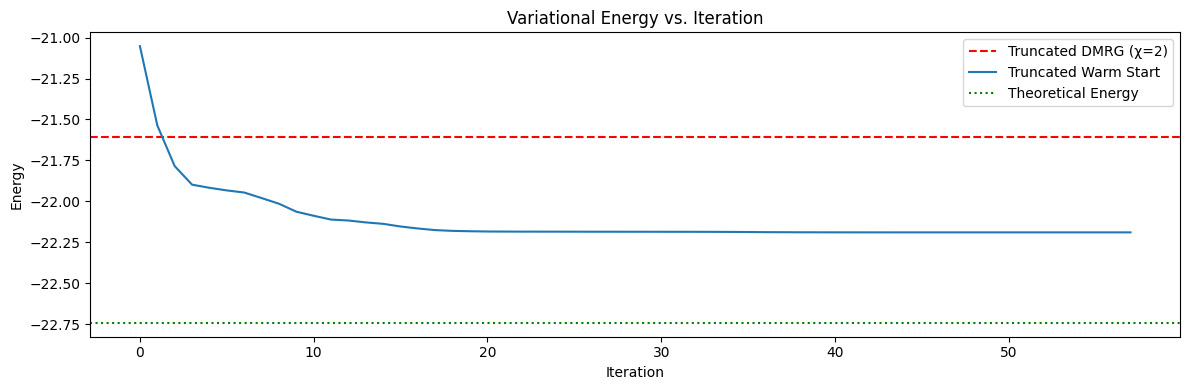

In [92]:
import matplotlib.pyplot as plt

# ... (after your optimization loop)

# Define the reference energies
dmrg_energy   = -21.604532836551563
theo_energy   = -22.7420414113324

plt.figure()


# Add horizontal lines
plt.axhline(y=dmrg_energy,
            color='r', linestyle='--',
            label=f'Truncated DMRG (χ=2)')
plt.plot(energies, label='Truncated Warm Start')
plt.axhline(y=theo_energy,
            color='g', linestyle=':',
            label=f'Theoretical Energy')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Variational Energy vs. Iteration')
plt.legend()
plt.tight_layout()
plt.show()


# Standard Ansatz

### EfficientSU2

### SciPy

Initial energy (θ = init_vals): -21.05218800
Optimized energy: -21.05605021
Exact ground-state energy: -22.74204141
Energy error: 1.69e+00
Percentage error (%): 7.4135


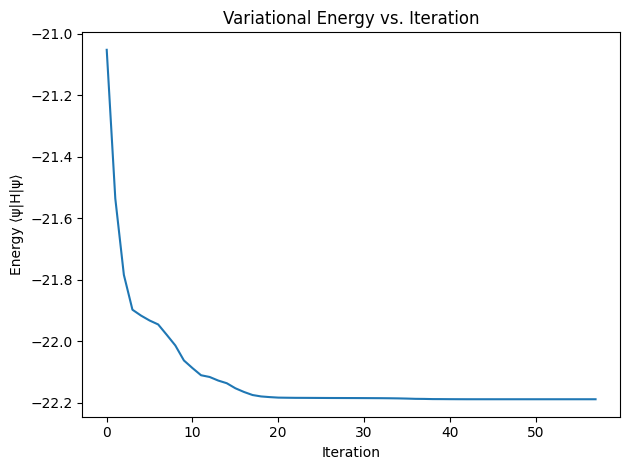

In [86]:

n_qubits = hamiltonian.num_qubits  
qc = EfficientSU2(num_qubits=n_qubits, reps=1)

qc.decompose().draw(output="mpl", style="iqp")


params = list(qc.parameters) 
num_params = len(params)


def energy(param_vals):
    
    bound_circ = qc.assign_parameters(
        {p: v for p, v in zip(params, param_vals)},
        inplace=False
    )
    
    psi = Statevector.from_instruction(bound_circ).data

    
    if isinstance(hamiltonian, np.ndarray):
        H_mat = hamiltonian
    else:
        H_mat = Operator(hamiltonian).data

    return np.real(np.vdot(psi, H_mat.dot(psi)))



init_vals = np.ones(num_params)

energies_SU2 = []

def record_energy(xk):

    energies_SU2.append(energy(xk))



res = minimize(
    fun=energy,
    x0=init_vals,
    method='L-BFGS-B',
    callback=record_energy,
    options={
        'maxiter': 2000,
        'ftol': 1e-6,
        'disp': True
    }
)

opt_vals = res.x 


print(f"Initial energy (θ = init_vals): {energies[0]:.8f}")
print(f"Optimized energy: {res.fun:.8f}")
if 'groundstate_value' in globals():
    print(f"Exact ground-state energy: {groundstate_value:.8f}")
    print(f"Energy error: {res.fun - groundstate_value:.2e}")
    print(f"Percentage error (%): {np.abs((res.fun - groundstate_value) / groundstate_value) * 100:.4f}")

plt.figure()
plt.plot(energies)
plt.xlabel('Iteration')
plt.ylabel('Energy ⟨ψ|H|ψ⟩')
plt.title('Variational Energy vs. Iteration')
plt.tight_layout()
plt.show()

### VQE Function

VQE on Aer qasm simulator (no noise): -20.10205
Delta from reference energy value is 2.63999
Percentage error (%):  11.608415378109493


Text(0.5, 1.0, 'Convergence with no noise')

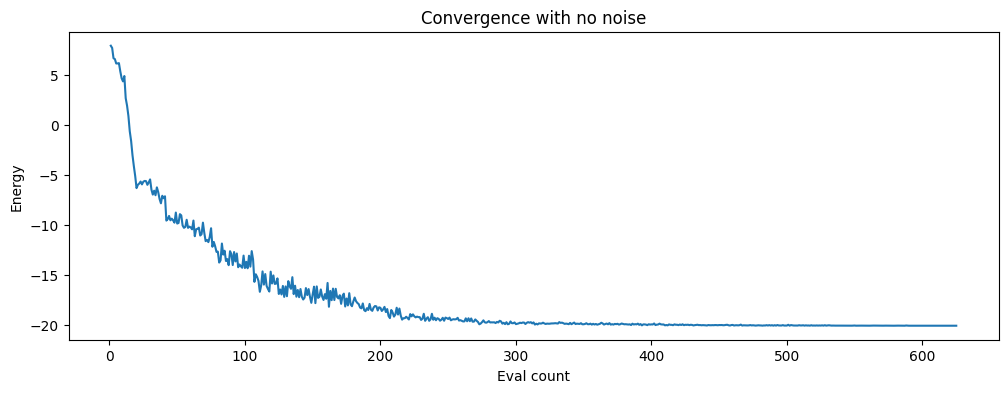

In [273]:
qc = EfficientSU2(hamiltonian.num_qubits, reps = 1)
qc.decompose().draw("mpl", style="iqp")
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

seed = 175
algorithm_globals.random_seed = seed

estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

optimizer = COBYLA(maxiter=2000)

num_params = qc.num_parameters
x0 = np.ones((num_params))

vqe = VQE(estimator=estimator, ansatz=qc, optimizer=optimizer, initial_point=x0,  callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result.eigenvalue.real - groundstate_value):.5f}")
print(f"Percentage error (%): ", (np.abs((groundstate_value - result.eigenvalue.real) / groundstate_value) * 100))
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

### Chem-inspired: UCCSD

### SciPy

Initial energy (θ = init_vals): -21.05218800
Optimized energy: -20.59117896
Exact ground-state energy: -22.74204141
Energy error: 2.15e+00
Percentage error (%): 9.4576


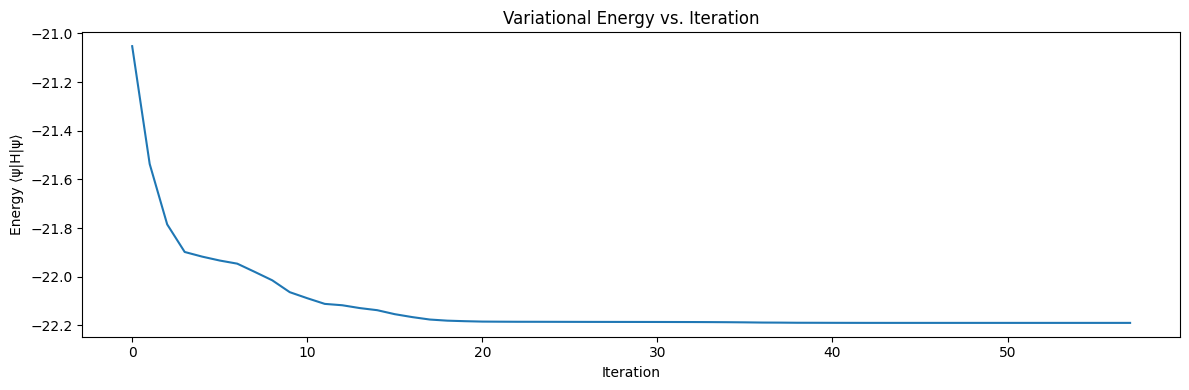

In [90]:
n_qubits = hamiltonian.num_qubits  
qc = TwoLocal(
    num_qubits=10,
    rotation_blocks=["ry"],       # like single-excitation rotations
    entanglement_blocks=["cx"],   # like hopping terms
    entanglement="linear",
    reps=1
)

qc.decompose().draw(output="mpl", style="iqp")


params = list(qc.parameters) 
num_params = len(params)


def energy(param_vals):
    
    bound_circ = qc.assign_parameters(
        {p: v for p, v in zip(params, param_vals)},
        inplace=False
    )
    
    psi = Statevector.from_instruction(bound_circ).data

    
    if isinstance(hamiltonian, np.ndarray):
        H_mat = hamiltonian
    else:
        H_mat = Operator(hamiltonian).data

    return np.real(np.vdot(psi, H_mat.dot(psi)))



init_vals = np.ones(num_params)

energies_UCCSD = []

def record_energy(xk):

    energies_UCCSD.append(energy(xk))



res = minimize(
    fun=energy,
    x0=init_vals,
    method='L-BFGS-B',
    callback=record_energy,
    options={
        'maxiter': 2000,
        'ftol': 1e-6,
        'disp': True
    }
)

opt_vals = res.x 


print(f"Initial energy (θ = init_vals): {energies[0]:.8f}")
print(f"Optimized energy: {res.fun:.8f}")
if 'groundstate_value' in globals():
    print(f"Exact ground-state energy: {groundstate_value:.8f}")
    print(f"Energy error: {res.fun - groundstate_value:.2e}")
    print(f"Percentage error (%): {np.abs((res.fun - groundstate_value) / groundstate_value) * 100:.4f}")

plt.figure()
plt.plot(energies)
plt.xlabel('Iteration')
plt.ylabel('Energy ⟨ψ|H|ψ⟩')
plt.title('Variational Energy vs. Iteration')
plt.tight_layout()
plt.show()

### VQE Function

VQE on Aer qasm simulator (no noise): -19.65283
Delta from reference energy value is 3.08921
Percentage error (%):  13.583694297980145


Text(0.5, 1.0, 'Convergence with no noise')

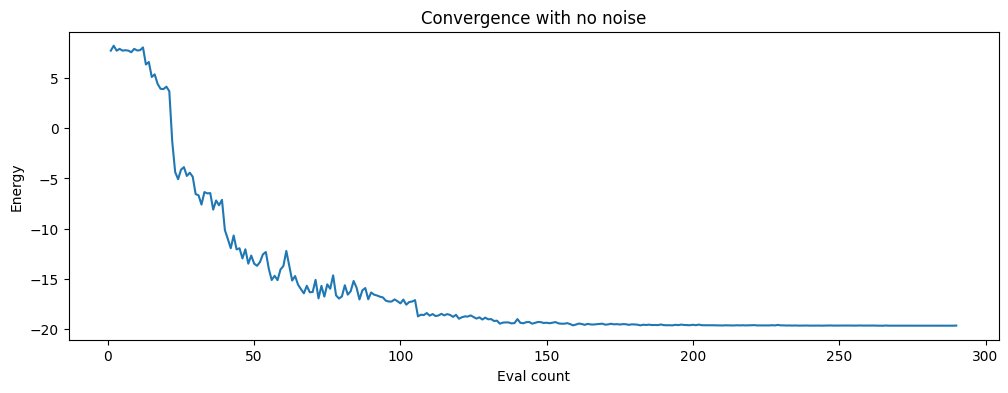

In [87]:
qc = TwoLocal(
    num_qubits=10,
    rotation_blocks=["ry"],       # like single-excitation rotations
    entanglement_blocks=["cx"],   # like hopping terms
    entanglement="linear",
    reps=1
)
qc.decompose().draw("mpl")

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

seed = 175
algorithm_globals.random_seed = seed

estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

optimizer = COBYLA(maxiter=2000)

num_params = qc.num_parameters
x0 = np.ones(num_params)

vqe = VQE(estimator=estimator, ansatz=qc, optimizer=optimizer, initial_point=x0,  callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result.eigenvalue.real - groundstate_value):.5f}")
print(f"Percentage error (%): ", (np.abs((groundstate_value - result.eigenvalue.real) / groundstate_value) * 100))

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

# Convergence Graphs

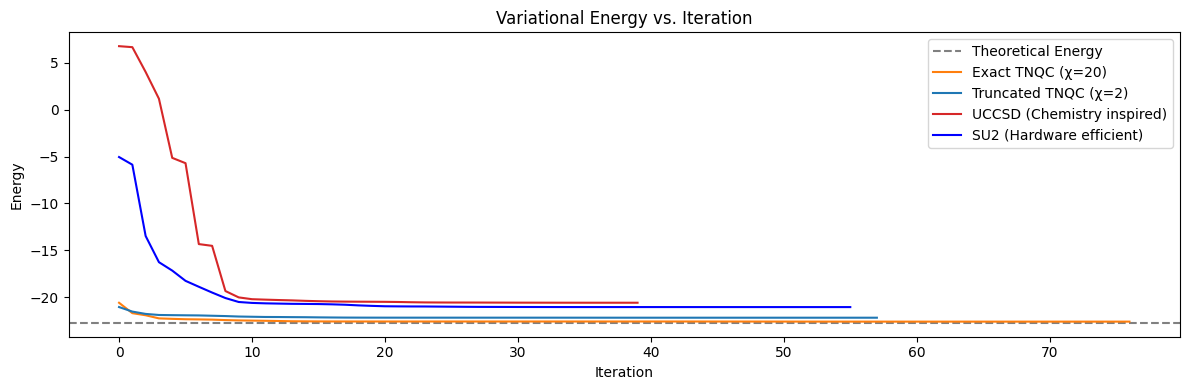

In [91]:
import matplotlib.pyplot as plt

plt.figure()

# Theoretical energy line
theo_energy = -22.7420414113324
plt.axhline(
    y=theo_energy,
    color='gray',
    linestyle='--',
    label='Theoretical Energy'
)

# Convergence curves with explicit colors and labels
plt.plot(
    energies_exact,
    color='tab:Orange',
    label='Exact TNQC (χ=20)')

plt.plot(
    energies_truncated,
    color='tab:blue',
    label='Truncated TNQC (χ=2)'
)
plt.plot(
    energies_UCCSD,
    color='tab:Red',
    label='UCCSD (Chemistry inspired)'
)
plt.plot(
    energies_SU2,
    color='b',
    label='SU2 (Hardware efficient)'
)

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Variational Energy vs. Iteration')
plt.legend()
plt.tight_layout()
plt.show()
